In this file we try to train a ConvNet from scrach. 

In [1]:
%matplotlib inline

In [1]:
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Lambda, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model, multi_gpu_model
import tensorflow as tf
from keras.callbacks import Callback, ModelCheckpoint, History, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from utils import plots
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [3]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
batch_size=32
G = 4 # number of GPU's

In [5]:
train_datagen = ImageDataGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path+'split_patients/train/',  # this is the target directory
        target_size=(256, 320),  
        batch_size=batch_size*G,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        path+'split_patients/validation/',
        target_size=(256, 320),
        batch_size=batch_size*G,
        shuffle=False,
        class_mode='categorical')

Found 5895 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.


In [ ]:
show_gen = ImageDataGenerator(rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='nearest',).flow_from_directory(path+'split_patients/train/', target_size=(256, 320), class_mode='categorical', shuffle=True,
                                    batch_size=8)

In [12]:
show_batch, show_label = next(show_gen)

Found 5895 images belonging to 4 classes.


In [13]:
show_class = show_label.argmax(axis=1)

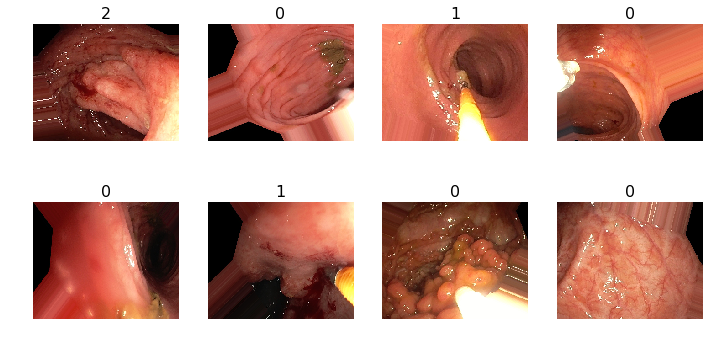

In [14]:
plots(show_batch, titles=show_class, rows=2)

## Model building and training

### Multi-GPU Model

In [11]:
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(341, 427, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())  
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
parallel_model = multi_gpu_model(model, gpus=G)

In [12]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
adam = Adam()
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [8]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 512, 640, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_4 (

### Single-GPU Model

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 320, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())  
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('sigmoid'))

In [7]:
adam = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [8]:
checkpointer = ModelCheckpoint(filepath=model_path+'splitp0201.h5', verbose=0, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-7)

earlystop = EarlyStopping(patience=30)

In [9]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples // (batch_size),
            epochs=3,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // (batch_size),
            callbacks = [checkpointer, reduce_lr, earlystop],
            verbose=1);

Epoch 1/3


ResourceExhaustedError: OOM when allocating tensor with shape[128,128,160,32]
	 [[Node: max_pooling2d_1/MaxPool = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_1/cond/Merge)]]
	 [[Node: loss/mul/_371 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3341_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'max_pooling2d_1/MaxPool', defined at:
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-6f9090fee4e8>", line 5, in <module>
    model.add(MaxPooling2D((2, 2), strides=(2,2)))
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/layers/pooling.py", line 154, in call
    data_format=self.data_format)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/layers/pooling.py", line 217, in _pooling_function
    pool_mode='max')
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3466, in pool2d
    data_format=tf_data_format)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1958, in max_pool
    name=name)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2806, in _max_pool
    data_format=data_format, name=name)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,128,160,32]
	 [[Node: max_pooling2d_1/MaxPool = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_1/cond/Merge)]]
	 [[Node: loss/mul/_371 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3341_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [18]:
history.history

{'acc': [0.72896563401374792, 0.7348908076073204, 0.73522938883040223],
 'loss': [4.2890150838845145, 4.2730552807906887, 4.2675980012066095],
 'lr': [0.001, 0.001, 0.001],
 'val_acc': [0.75679347826086951, 0.75679347826086951, 0.75679347826086951],
 'val_loss': [3.9200260069059394, 3.9200260069059394, 3.9200260069059394]}

In [26]:
with open('history_hd.pkl', 'wb') as f:
    pickle.dump(history.history, f, -1)

## Result evaluation

In [9]:
with open('output/oversample0125.pkl', 'rb') as f:
    history = pickle.load(f)

In [11]:
history.keys()

dict_keys(['acc', 'val_loss', 'lr', 'loss', 'val_acc'])

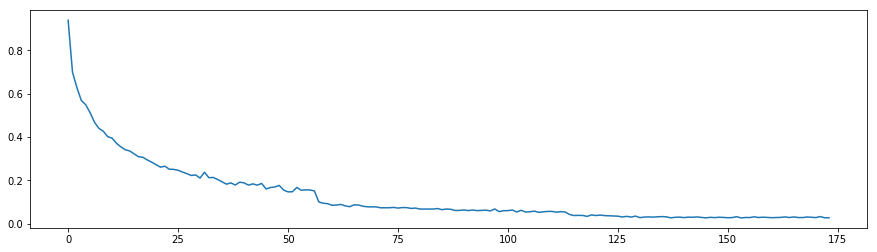

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(history['loss'])

In [48]:
model.load_weights(model_path+'oversample0130f.h5')

In [49]:
y_pred = model.predict_generator(validation_generator)
y_pred_class = y_pred.argmax(axis=1)

In [51]:
sum(y_pred_class == 0), sum(y_pred_class == 1),sum(y_pred_class == 2), sum(y_pred_class == 3)

(1252, 127, 57, 102)

In [53]:
class_gen = test_datagen.flow_from_directory(
        path+'split_patients/validation/',
        target_size=(4, 5),
        batch_size=1538,
        shuffle=False,
        class_mode='categorical')
X_waste, y_true = next(class_gen)

Found 1538 images belonging to 4 classes.


In [27]:
y_true_class = y_true.argmax(axis=1)

In [28]:
np.save('y_true_class_sp.npy', y_true_class)

In [52]:
y_true_class = np.load('output/y_true_class_sp.npy')

In [46]:
y_true_class.shape

(1494,)

In [14]:
df = pd.DataFrame(data=np.column_stack((y_true_class, y_pred_class)), columns=('true', 'pred'))

In [15]:
pd.crosstab(index=df.true, columns=df.pred, margins=True)

pred,0,1,2,3,All
true,,,,,
0,914,45,0,49,1008
1,167,44,3,50,264
2,142,28,23,3,196
3,29,10,31,0,70
All,1252,127,57,102,1538


In [58]:
pd.crosstab(index=df.true, columns=df.pred).apply(lambda r: r/r.sum(), axis=1)

pred,0,1,2,3
true,,,,
0,0.968582,0.025135,0.005386,0.000898
1,0.212963,0.745370,0.041667,0.000000
2,0.042735,0.059829,0.871795,0.025641
3,0.085106,0.042553,0.148936,0.723404


In [55]:
n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

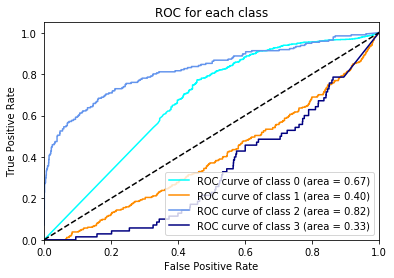

In [60]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for each class')
plt.legend(loc="lower right")

### Zero/Non-zero Classification

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 320, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())  
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [18]:
model.load_weights(model_path+'splitp_znz0124f.h5')

In [19]:
train_datagen = ImageDataGenerator( 
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path+'zero_nzero/train/',  # this is the target directory
        target_size=(256, 320),  
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        path+'zero_nzero/validation/',
        target_size=(256, 320),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 5895 images belonging to 2 classes.
Found 1538 images belonging to 2 classes.


In [21]:
class_gen = test_datagen.flow_from_directory(
        path+'zero_nzero/validation/',
        target_size=(4, 5),
        batch_size=1538,
        shuffle=False,
        class_mode='categorical')
X_waste, y_true = next(class_gen)

Found 1538 images belonging to 2 classes.


In [23]:
y_true_class = y_true.argmax(axis=1)

In [22]:
y_pred = model.predict_generator(validation_generator)
y_pred_class = y_pred.argmax(axis=1)

In [24]:
df = pd.DataFrame(data=np.column_stack((y_true_class, y_pred_class)), columns=('true', 'pred'))

In [25]:
pd.crosstab(index=df.true, columns=df.pred, margins=True)

pred,0,1,All
true,,,
0,956,52,1008
1,453,77,530
All,1409,129,1538


In [45]:
fpr, tpr, _ = roc_curve(y_true[:, 0], y_pred[:, 0])

roc_auc = auc(fpr, tpr)

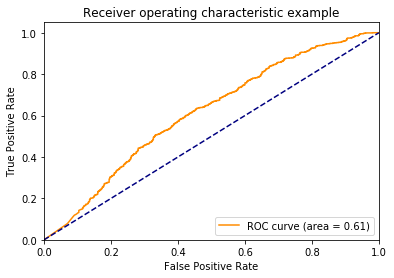

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")